## The Model
Probabilistic principal components analysis (PCA) is a
dimensionality reduction technique that
analyzes data via a lower dimensional latent space
([Tipping and Bishop 1999](#1)). It is often
used when there are missing values in the data or for multidimensional
scaling.


Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

$$
\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}
$$

The corresponding data point is generated via a projection,

$$
\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}
$$

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

$$
\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^\top + \sigma^2\mathbf{I}).
\end{equation*}
$$

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we assume $\sigma$ is known, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes.

c:\Users\SSosa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


jax.local_device_count 16


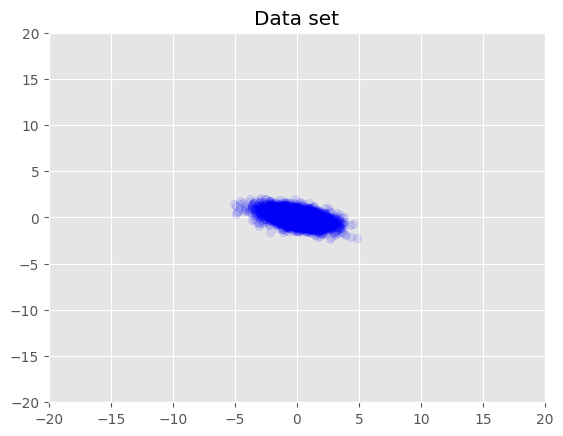

In [2]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *
import seaborn as sns

m = bi(platform='cpu')
plt.style.use("ggplot")
warnings.filterwarnings('ignore')


num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

# Simulate data
def sim_data(data_dim, latent_dim, num_datapoints, stddv_datapoints, seed = 0): 
    w = bi.dist.normal(0, 1, shape=(data_dim, latent_dim), name='w', sample=True, seed=seed)
    z = bi.dist.normal(0, 1, shape=(latent_dim, num_datapoints), name='z', sample=True, seed=seed)
    x = bi.dist.normal(w @ z, stddv_datapoints, name='x', sample=True, seed=seed)
    return w, z, x

actual_w, actual_z, x_train =sim_data(data_dim, latent_dim, num_datapoints, stddv_datapoints, seed = 20)
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()


## Model

In [15]:
# Model using simulated data
def model(x_train, data_dim, latent_dim, num_datapoints, stddv_datapoints, seed = 0): 
    w = bi.dist.normal(0, 1, shape=(data_dim, latent_dim), name='w')
    z = bi.dist.normal(0, 1, shape=(latent_dim, num_datapoints), name='z')
    lk('Y', Normal(w @ z, stddv_datapoints), obs = x_train)  
    
m.data_on_model = dict(
    x_train = x_train, 
    data_dim = data_dim, 
    latent_dim = latent_dim, 
    num_datapoints = num_datapoints, 
    stddv_datapoints = stddv_datapoints
)

m.run(model) 
summary = m.summary()
real_data = jnp.concatenate([actual_w.flatten(), actual_z.flatten()]) # concatenate the actual values of w and z
posteriors = summary.iloc[:,0]

sample: 100%|██████████| 1000/1000 [00:11<00:00, 84.44it/s, 31 steps of size 1.86e-01. acc. prob=0.81] 


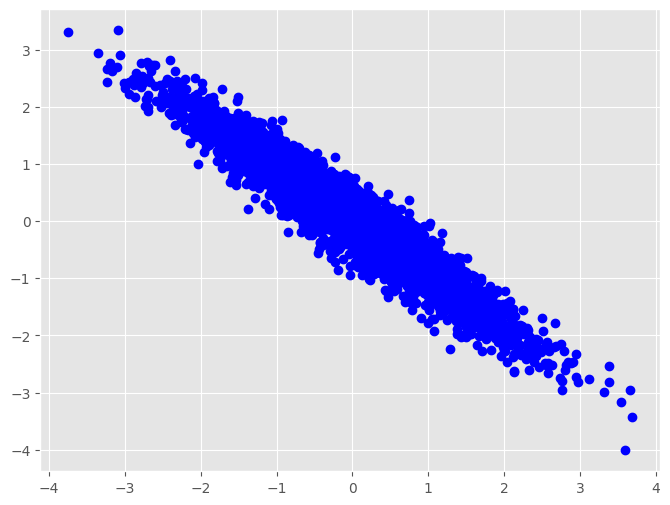

In [177]:
# Plot real values Vs expected values
plt.figure(figsize=(8, 6))
plt.plot(real_data, posteriors, marker='o', linestyle='None', color='b', label='Posteriors')

Estimations are inverted due to **Sign Ambiguity in PCA**: 

Principal Component Analysis (PCA) identifies directions (principal components) that capture the maximum variance in the data. However, the orientation of these components is not unique; both a vector and its negation represent the same principal direction. This means that if 𝑤 is a principal component, −𝑤 is equally valid.

To resolve this issue, you can align the signs of the estimated parameters with the true parameters before comparison. Here's how you can adjust the comparison:

Compute the Dot Product: Calculate the dot product between the true parameters and the estimated parameters. This will help determine the relative orientation.

Align Signs: If the dot product is negative, multiply the estimated parameters by -1 to align them with the true parameters.

Plot the Aligned Parameters: After alignment, plot the true parameters against the adjusted estimates to assess the correlation accurately.

In [42]:
jnp.array(real_data)

Array([-1.23922889,  0.36825474,  0.62630263, ..., -1.91575952,
       -0.42101356, -0.44178383], dtype=float64)

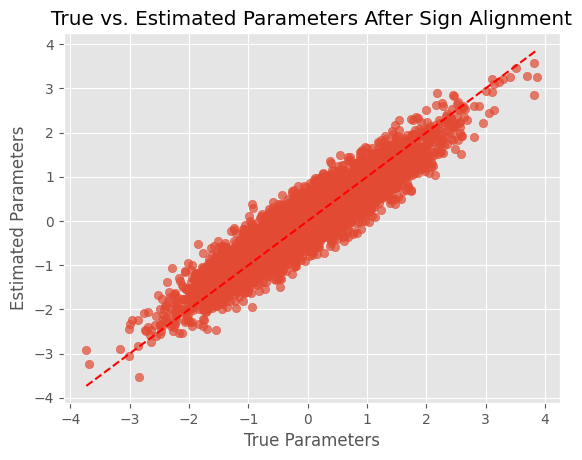

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'true_params' and 'estimated_params' are your parameter vectors
true_params = jnp.array(real_data)      # Replace with actual true parameters
estimated_params = jnp.array(posteriors)  # Replace with actual estimated parameters

# Compute dot product
dot_product = jnp.dot(true_params, estimated_params)

# Align signs if necessary
if dot_product < 0:
    estimated_params = -estimated_params

# Plot the aligned parameters
plt.scatter(true_params, estimated_params, alpha=0.7)
plt.plot([min(true_params), max(true_params)], [min(true_params), max(true_params)], 'r--')
plt.xlabel('True Parameters')
plt.ylabel('Estimated Parameters')
plt.title('True vs. Estimated Parameters After Sign Alignment')
plt.show()

# References
<a name='1'></a>[1]: Michael E. Tipping and Christopher M. Bishop. Probabilistic principal component analysis. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 61(3): 611-622, 1999.